In [12]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, create_idx
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [15]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

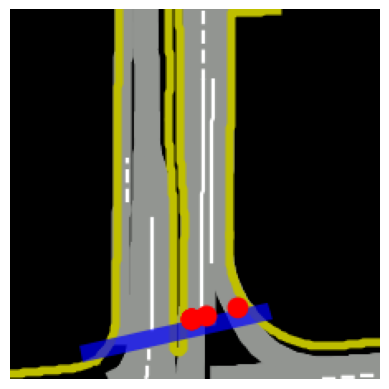

In [16]:
image_buffer = road_map[0].numpy() / 255.0
plt.imshow(image_buffer)
plt.axis('off')
plt.show()